# Setup

In [1]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-09 13:29:18.681749: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
config = json.load(open("./configs/ext_mnn_em_flickr30k.json"))

# Loading data

In [7]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data = data[['description', 'description2', 'path', 'label']]
data

,description,description2,path,label
0,two teenagers walking down the street with an ...,two asian woman at an archery competition gett...,431018958.jpg,0
1,performers in costumes are performing at a par...,a brunette wearing eyeglasses and white sweate...,1698837338.jpg,0
2,a woman off her bike looking at the area .,horseback riders file down a wooded path .,2427731202.jpg,0
3,two people on motorbikes .,two people on motorbikes .,3104400277.jpg,1
4,multiple people are hanging on to a pole while...,a man holding a little girl up in the air outs...,2868575889.jpg,0
...,...,...,...,...
317822,a chubby woman with her boyfriend .,two men wearing plastic gloves are making juic...,5105885364.jpg,0
317823,two soccer players rush to kick the ball .,two soccer players rush to kick the ball .,2962977152.jpg,1
317824,an african walks through a field .,an african walks through a field .,3203653158.jpg,1
317825,a woman wearing shades and a coat looks upward .,a man in a white collared shirt plays a red gu...,4897359709.jpg,0


In [8]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [9]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(317827, 1014)

In [10]:
text2 = tk.tokenize(text2)
text2.shape

(317827, 1014)

## Create embedding weights

In [11]:
weights = tk.create_embedding_weights()
weights.shape

(58, 57)

# Image processing

## Load image model

In [12]:
from utils.img_processing import load_img_model, create_embeddings_from

In [13]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [14]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "flickr30k_images"),
                             batch_size=1024)

Found 317827 validated image filenames.


In [15]:
img.shape

(317827, 576)

# Save embeddings

In [16]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [17]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [29]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,label
0,two teenagers walking down the street with an ...,two asian woman at an archery competition gett...,431018958.jpg,0
1,performers in costumes are performing at a par...,a brunette wearing eyeglasses and white sweate...,1698837338.jpg,0
2,a woman off her bike looking at the area .,horseback riders file down a wooded path .,2427731202.jpg,0
3,two people on motorbikes .,two people on motorbikes .,3104400277.jpg,1
4,multiple people are hanging on to a pole while...,a man holding a little girl up in the air outs...,2868575889.jpg,0
...,...,...,...,...
317822,a chubby woman with her boyfriend .,two men wearing plastic gloves are making juic...,5105885364.jpg,0
317823,two soccer players rush to kick the ball .,two soccer players rush to kick the ball .,2962977152.jpg,1
317824,an african walks through a field .,an african walks through a field .,3203653158.jpg,1
317825,a woman wearing shades and a coat looks upward .,a man in a white collared shirt plays a red gu...,4897359709.jpg,0


In [30]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(317827, 576)

In [31]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(317827, 1014)

In [32]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(317827, 1014)

# Train-Test Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [35]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

text2_train = text2[train.index]
text2_test = text2[test.index]

# Save Char CNN config

In [36]:
from models.char_cnn_zhang import CharCNNZhang

In [37]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [38]:
char_cnn = CharCNNZhang(**char_cnn_config)
char_cnn.model

# Build Extended MNN-EM Model

![](../../assets/images/Extended_MNN_EM.png)

In [39]:
from models.mnn_em import ExtendedMNNEM
from utils.metrics import create_metrics

In [40]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_1_fc_layers"],
    "extended": True,
}

In [41]:
head_2_config = {
    "img_input_size": config["model"]["img_1_fc_layers"][-1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["combined_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_2_fc_layers"],
    "extended": False,
}

In [42]:
ext_mnn_em = ExtendedMNNEM(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    char_cnn=char_cnn.model,
    combined_fc_layers=config["model"]["combined_2_fc_layers"],
    learning_rate=config["model"]["training"]["learning_rate"],
    metrics=create_metrics(config["model"]["training"]["metrics"]))

In [43]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         16112106    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                  

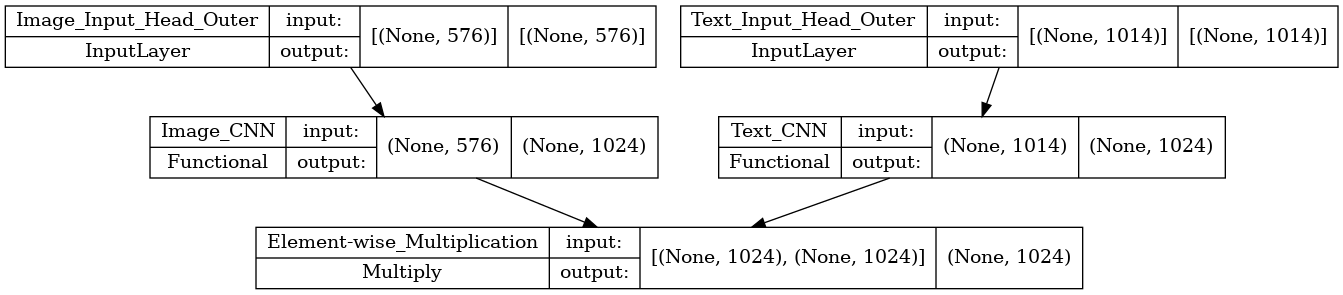

In [44]:
# "Head"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

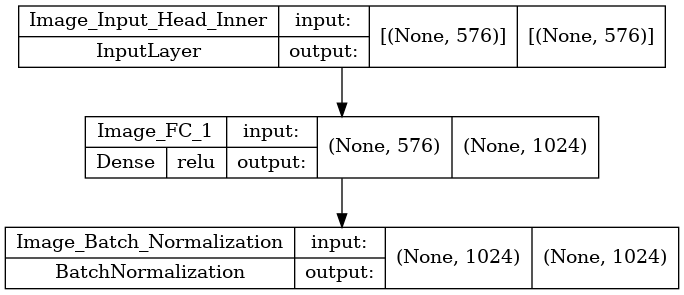

In [45]:
# Image CNN

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

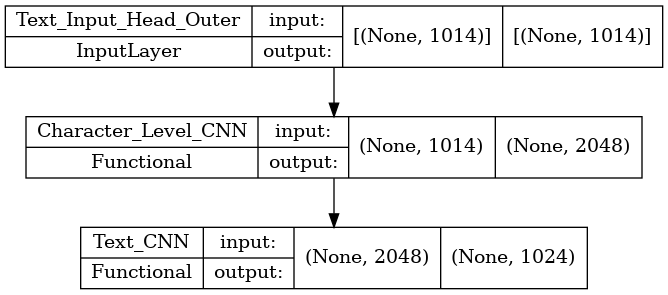

In [46]:
# Text CNN (outer)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

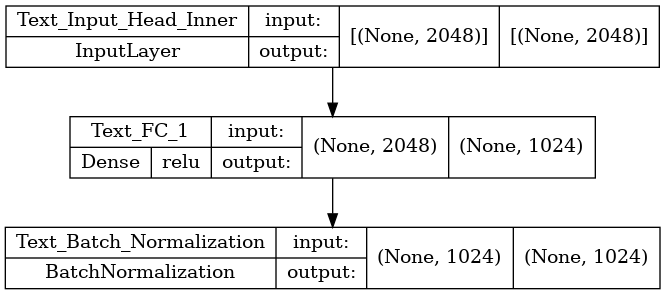

In [47]:
# Text CNN (inner)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3].layers[-1],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

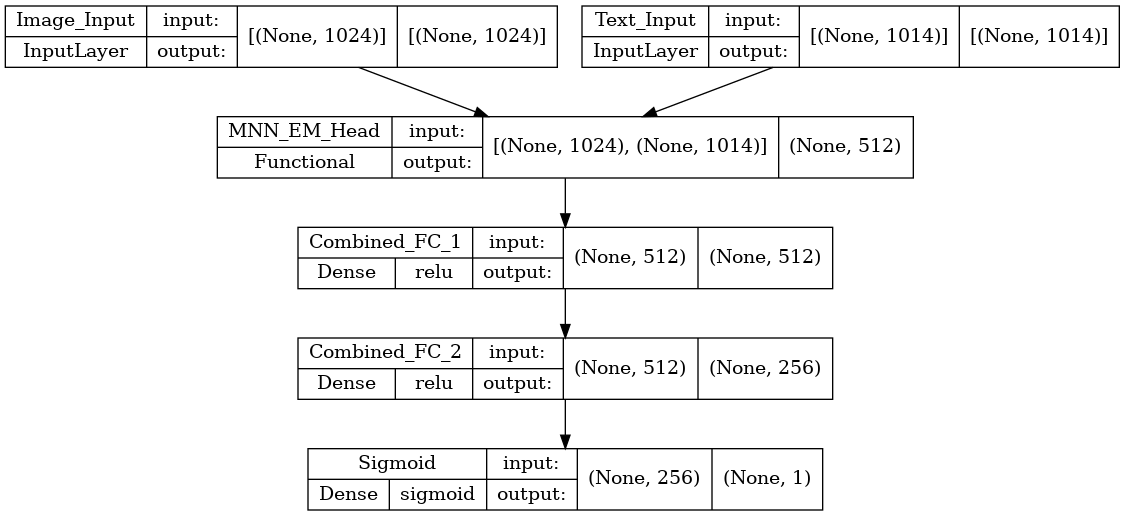

In [48]:
# "Tail"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[4],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

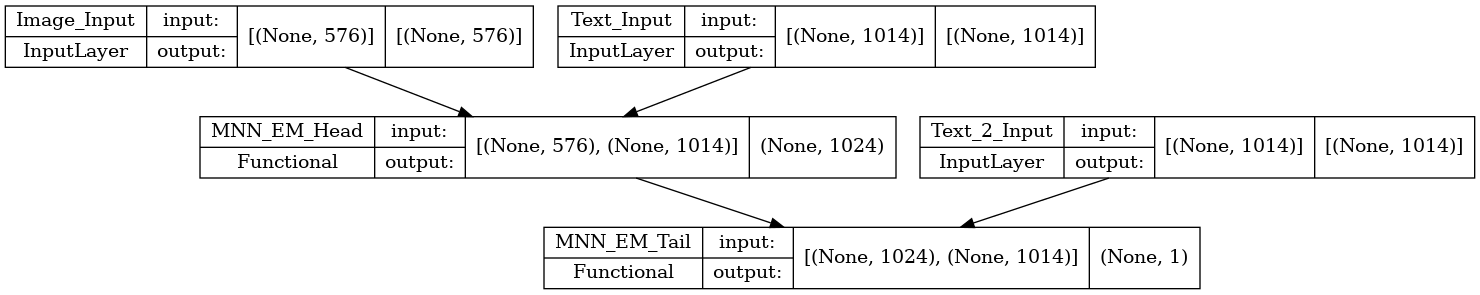

In [49]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model,
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [50]:
from utils.metrics import create_callbacks

In [51]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [52]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [53]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
16090/16090 [==============================] - ETA: 0s - loss: 2.3824 - recall: 0.7493 - precision: 0.6215 - binary_accuracy: 0.6463 - cosine_similarity: 0.5003

2023-06-09 14:07:37.520314: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 328s 20ms/step - loss: 2.3824 - recall: 0.7493 - precision: 0.6215 - binary_accuracy: 0.6463 - cosine_similarity: 0.5003 - val_loss: 0.7040 - val_recall: 0.9806 - val_precision: 0.6687 - val_binary_accuracy: 0.7459 - val_cosine_similarity: 0.5016
Epoch 2/10
16090/16090 [==============================] - ETA: 0s - loss: 0.3564 - recall: 0.9721 - precision: 0.8215 - binary_accuracy: 0.8803 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 327s 20ms/step - loss: 0.3564 - recall: 0.9721 - precision: 0.8215 - binary_accuracy: 0.8803 - cosine_similarity: 0.5003 - val_loss: 0.2817 - val_recall: 0.9949 - val_precision: 0.8737 - val_binary_accuracy: 0.9252 - val_cosine_similarity: 0.5022
Epoch 3/10
16090/16090 [==============================] - ETA: 0s - loss: 0.2538 - recall: 0.9726 - precision: 0.8742 - binary_accuracy: 0.9162 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 327s 20ms/step - loss: 0.2538 - recall: 0.9726 - precision: 0.8742 - binary_accuracy: 0.9162 - cosine_similarity: 0.5003 - val_loss: 0.2267 - val_recall: 0.9971 - val_precision: 0.8727 - val_binary_accuracy: 0.9254 - val_cosine_similarity: 0.5024
Epoch 4/10
16090/16090 [==============================] - ETA: 0s - loss: 0.2373 - recall: 0.9741 - precision: 0.8766 - binary_accuracy: 0.9185 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 328s 20ms/step - loss: 0.2373 - recall: 0.9741 - precision: 0.8766 - binary_accuracy: 0.9185 - cosine_similarity: 0.5003 - val_loss: 0.2170 - val_recall: 0.9974 - val_precision: 0.8772 - val_binary_accuracy: 0.9285 - val_cosine_similarity: 0.5025
Epoch 5/10
16090/16090 [==============================] - ETA: 0s - loss: 0.2114 - recall: 0.9788 - precision: 0.8915 - binary_accuracy: 0.9298 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 326s 20ms/step - loss: 0.2114 - recall: 0.9788 - precision: 0.8915 - binary_accuracy: 0.9298 - cosine_similarity: 0.5003 - val_loss: 0.2152 - val_recall: 0.9933 - val_precision: 0.9144 - val_binary_accuracy: 0.9499 - val_cosine_similarity: 0.5019
Epoch 6/10
16088/16090 [============================>.] - ETA: 0s - loss: 0.1384 - recall: 0.9873 - precision: 0.9374 - binary_accuracy: 0.9607 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 326s 20ms/step - loss: 0.1384 - recall: 0.9873 - precision: 0.9374 - binary_accuracy: 0.9607 - cosine_similarity: 0.5003 - val_loss: 0.1349 - val_recall: 0.9976 - val_precision: 0.9474 - val_binary_accuracy: 0.9709 - val_cosine_similarity: 0.5024
Epoch 7/10
16089/16090 [============================>.] - ETA: 0s - loss: 0.1208 - recall: 0.9866 - precision: 0.9453 - binary_accuracy: 0.9647 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 327s 20ms/step - loss: 0.1208 - recall: 0.9866 - precision: 0.9453 - binary_accuracy: 0.9647 - cosine_similarity: 0.5003 - val_loss: 0.0971 - val_recall: 0.9992 - val_precision: 0.9476 - val_binary_accuracy: 0.9718 - val_cosine_similarity: 0.5028
Epoch 8/10
16088/16090 [============================>.] - ETA: 0s - loss: 0.1135 - recall: 0.9867 - precision: 0.9489 - binary_accuracy: 0.9668 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 330s 21ms/step - loss: 0.1135 - recall: 0.9867 - precision: 0.9489 - binary_accuracy: 0.9668 - cosine_similarity: 0.5003 - val_loss: 0.0959 - val_recall: 0.9997 - val_precision: 0.9492 - val_binary_accuracy: 0.9730 - val_cosine_similarity: 0.5028
Epoch 9/10
16089/16090 [============================>.] - ETA: 0s - loss: 0.1053 - recall: 0.9869 - precision: 0.9527 - binary_accuracy: 0.9690 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 329s 20ms/step - loss: 0.1053 - recall: 0.9869 - precision: 0.9527 - binary_accuracy: 0.9690 - cosine_similarity: 0.5003 - val_loss: 0.0801 - val_recall: 0.9992 - val_precision: 0.9594 - val_binary_accuracy: 0.9783 - val_cosine_similarity: 0.5028
Epoch 10/10
16090/16090 [==============================] - 318s 20ms/step - loss: 0.0970 - recall: 0.9869 - precision: 0.9565 - binary_accuracy: 0.9710 - cosine_similarity: 0.5003 - val_loss: 0.0917 - val_recall: 0.9999 - val_precision: 0.9487 - val_binary_accuracy: 0.9728 - val_cosine_similarity: 0.5029


# Evaluation

## Plot loss and metrics

In [54]:
from utils.metrics import plot_metrics

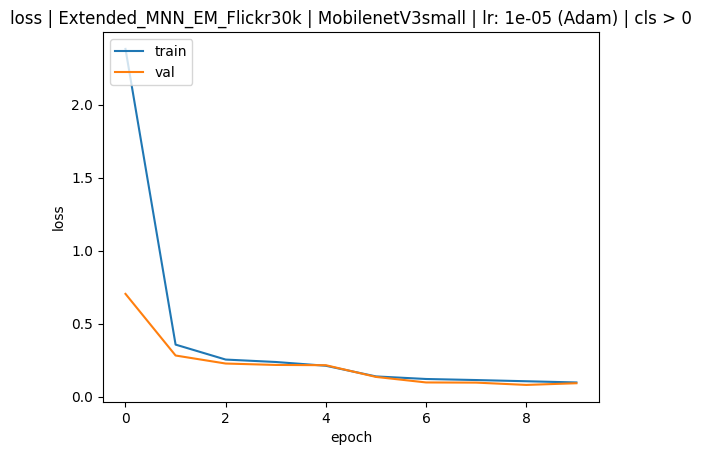

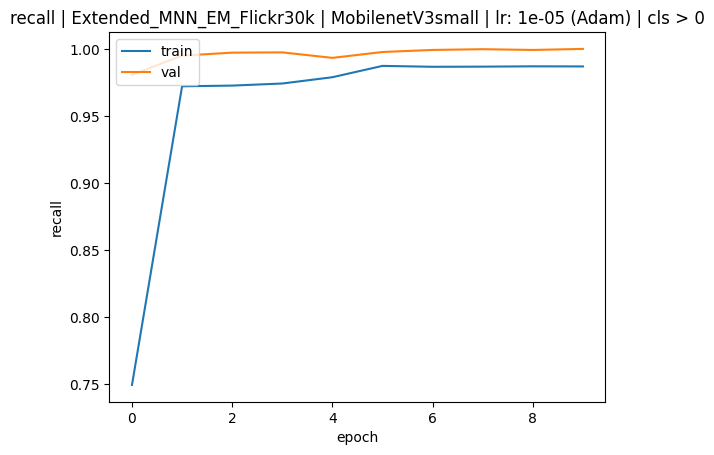

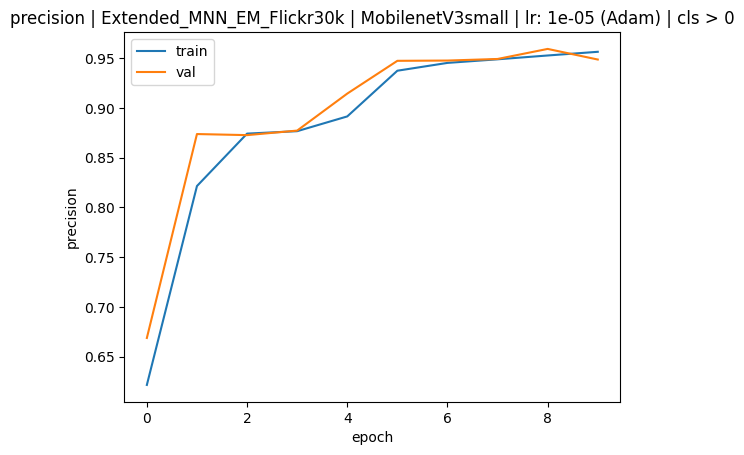

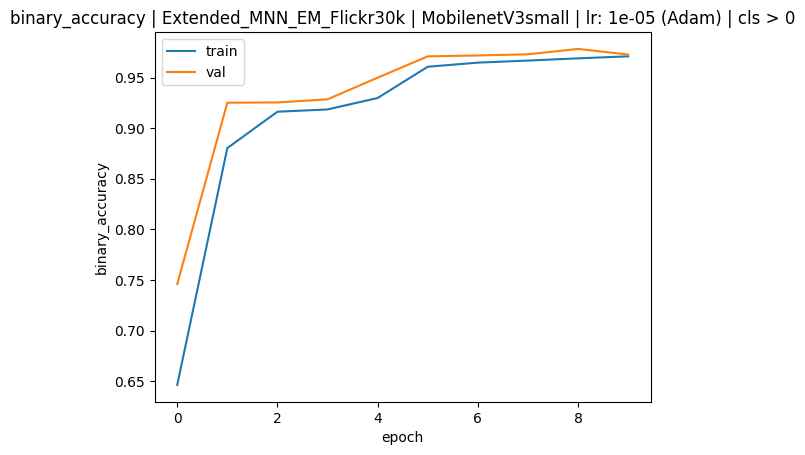

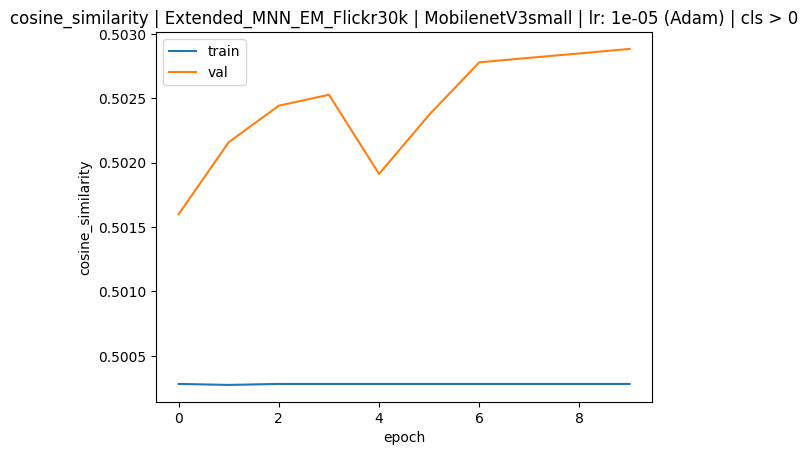

In [55]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [56]:
from utils.metrics import evaluate

In [57]:
evaluate(ext_mnn_em.model, [img_test, text_test, text2_test], labels_test,
         log_dir, model_name, img_model.name, optimizer_name, learning_rate,
         config["data"]["cls"])

31783/31783 [==============================] - 187s 6ms/step - loss: 0.1002 - recall: 0.9998 - precision: 0.9452 - binary_accuracy: 0.9712 - cosine_similarity: 0.4951
